# Physics 256
## Solving Laplace's Equation

\begin{eqnarray}
\nabla \cdot \vec{E} &= \frac{\rho}{\varepsilon_0} \quad&\quad \nabla \times \vec{E} &= -\frac{\partial\vec{B}}{\partial t} \newline
\nabla \cdot \vec{B} &= 0 \quad&\quad \nabla \times \vec{B} &= \mu_0 \left(\vec{J} +\varepsilon_0 \frac{\partial\vec{E}}{\partial t}\right)
\end{eqnarray}

## Last Time

- Fast Fourier transform
- Using the FFT to analyze chaos

## Today

- Elliptical differential equations
- Spatial discretization and the Laplace equation

## Setting up the Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('notebook');
%config InlineBackend.figure_format = 'retina'
colors = ["#2078B5", "#FF7F0F", "#2CA12C", "#D72827", "#9467BE", "#8C574B",
            "#E478C2", "#808080", "#BCBE20", "#17BED0", "#AEC8E9", "#FFBC79", 
            "#98E08B", "#FF9896", "#C6B1D6", "#C59D94", "#F8B7D3", "#C8C8C8", 
           "#DCDC8E", "#9EDAE6"]

## Laplace's Equation

In the absence of any charge density ($\rho=0$) the scalar electric potential is related to the electric field via:

\begin{equation}
\vec{E} = -\nabla V
\end{equation}

and thus the first of Maxwell's equation is the Laplace equation for the scalar potential:

\begin{equation}
\nabla^2 V = 0.
\end{equation}

In three spatial dimensions this has the form of an *elliptic* partial differential equation:

\begin{equation}
\frac{\partial^2}{\partial x^2} V(x,y,z) + \frac{\partial^2}{\partial y^2} V(x,y,z) + \frac{\partial^2}{\partial z^2} V(x,y,z) = 0.
\end{equation}

This equation is very different than the ordinary differential equations (ODE) we have solved thus far in this class.  Here, we have a 2nd order partial differential equation (PDE) where we know the *boundary conditions*.  Unlike for the case of ODEs, there is no single class of systematic integrators which differ only by their accuracy.  Instead, we have to determine the best algorithm on a case-by-case basis.  For elliptical PDEs, we will study **relaxation** methods which work well.

## Discretization 
In analogy to our approach for ODEs (where we discretized time) we will discretize space by writing:

\begin{align}
x_i &= i \Delta x \newline
y_i &= i \Delta y \newline
z_i &= i \Delta z 
\end{align}

where $\Delta x, \Delta y, \Delta z \ll 1$ and we define:

\begin{equation}
V(x_i,y_j,z_k) = V_{ijk} = V(i,j,k). 
\end{equation}

Our first step is to write the Laplace equation as a *difference* equation.

### Forward Derivative
We have already used this discrete approximation to the deriviative derived from the Taylor expansion near $x_i$:

\begin{equation}
\frac{\partial V}{\partial x}  \approx \frac{V(i+1,j,k) - V(i,j,k)}{\Delta x}.
\end{equation}


### Backwards Derivative
We could also have expanded in the oppositie direction which would give:

\begin{equation}
\frac{\partial V}{\partial x}  \approx \frac{V(i,j,k) - V(i-1,j,k)}{\Delta x}.
\end{equation}

### Centered Derivative
Let's combine these two approaches.  Consider the Taylor expansion for a function $f$ of a single variable $x$:

\begin{align}
f(x+\Delta x) &= f(x) + f'(x) \Delta x + \frac{1}{2} f''(x) (\Delta x)^2 + \frac{1}{6} f'''(x)(\Delta x)^3 + \cdots \newline
f(x-\Delta x) &= f(x) - f'(x) \Delta x + \frac{1}{2} f''(x) (\Delta x)^2 - \frac{1}{6} f'''(x)(\Delta x)^3 + \cdots 
\end{align}

Subtracting these two expressions yields:

\begin{align}
f(x+\Delta x) - f(x-\Delta x) &= 2 f'(x) \Delta x + \frac{1}{3} f'''(x) (\Delta x)^3 \newline 
\Rightarrow f'(x) &= \frac{d f}{dx} = \frac{f(x+\Delta x) - f(x-\Delta x)}{2 \Delta x} + \mathrm{O}(\Delta x^2) .
\end{align}

This is the centered derivative and it is accurate to order $\Delta x^2$ as opposed to order $\Delta x$ for the forward and backward derivatives.

### 2nd Derivative
If we added instead of subtracting we would have found:

\begin{align}
f(x+\Delta x) + f(x-\Delta x) &= 2 f(x)  + f''(x) (\Delta x)^2 \newline 
\Rightarrow f''(x) &= \frac{d^2 f}{dx^2} = \frac{f(x+\Delta x) + f(x-\Delta x) - 2f(x)}{(\Delta x)^2} + \mathrm{O}(\Delta x^2) .
\end{align}

We can think of this as the combination of a forward and backward derivative at step $\Delta x/2$.


<div class="span alert alert-success">
<h2> Programming challenge </h2>

Consider the function $f(x) = \ln x$. 
<ol>
<li> Compare the forward and centered derivative of $f(x)$ on $x \in [2,3]$ with the exact result using $\Delta x = 0.1$.</li>
<li> Compare the 2nd derivative of $f(x)$ on $x \in [2,3]$ with the exact result. </li>
</ol>
</div>

In [2]:
def f(x):
    return np.log(x)

def df(f,x):
    '''Compute the forward, centered and 2nd derivative of f = ln(x)'''
    Δx = x[1]-x[0]
        
    dff = (f(x+Δx)-f(x))/Δx
    dcf = (f(x+Δx)-f(x-Δx))/(2*Δx)
    d2f = (f(x+Δx)+f(x-Δx)-2*f(x))/(Δx**2)
    
    return dff,dcf,d2f

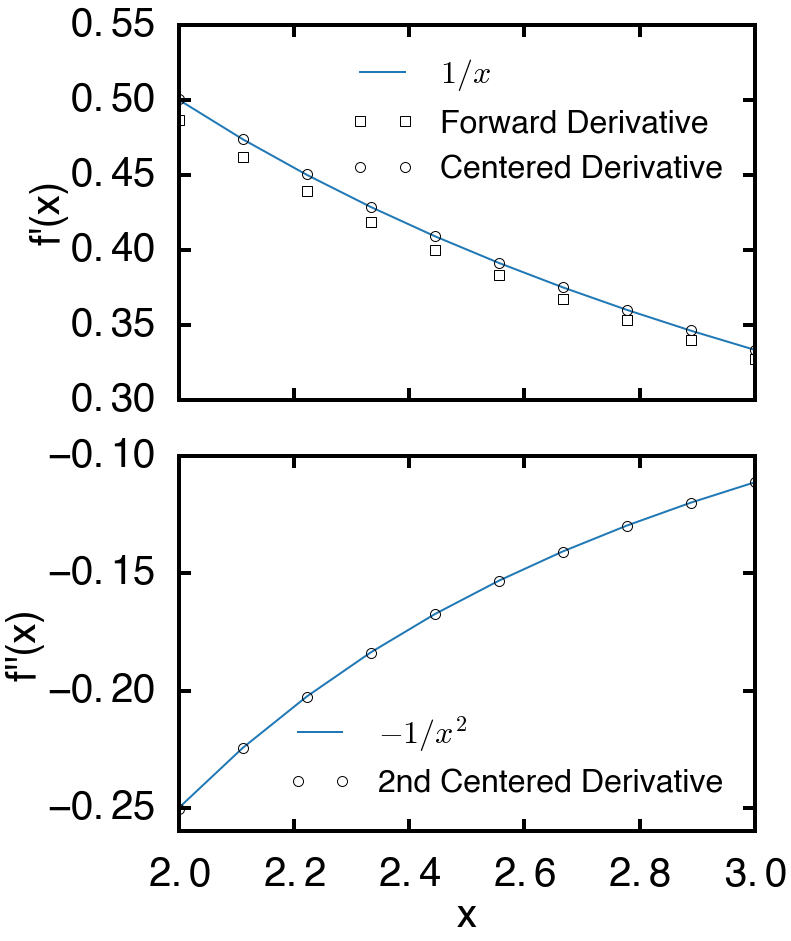

In [3]:
N = 10
x = np.linspace(2,3,N)
dff,dcf,d2f = df(f,x)

fig, axes = plt.subplots(2,1,sharex=True, sharey=False, squeeze=True, figsize=(5,7))

axes[0].plot(x,1/x, lw=1, label=r'$1/x$')
axes[0].plot(x,dff,'s', mfc='None', ms=5, label='Forward Derivative')
axes[0].plot(x,dcf,'o', mfc='None', ms=5, label='Centered Derivative')

axes[0].set_ylabel("f'(x)")
axes[0].legend()
axes[0].set_xlim(2,3)

axes[1].plot(x,-1/(x*x), lw=1, label=r'$-1/x^2$')
axes[1].plot(x,d2f,'o', mfc='None', ms=5, label='2nd Centered Derivative')
axes[1].set_xlabel('x')
axes[1].set_ylabel("f''(x)")
axes[1].legend(loc='lower right')


## Discretizing the Laplace Equation

We can now apply our centered 2nd derivative to the Laplace equation:

\begin{align}
\frac{\partial^2}{\partial x^2} V(x,y,z) + \frac{\partial^2}{\partial y^2} V(x,y,z) + \frac{\partial^2}{\partial z^2} V(x,y,z) &\approx  \frac{1}{(\Delta x)^2}\left[V(i+1,j,k)+V(i-1,j,k) - 2V(i,j,k)\right] \newline
&+ \; \frac{1}{(\Delta y)^2}\left[V(i,j+1,k)+V(i,j-1,k) - 2V(i,j,k)\right] \newline
&+ \; \frac{1}{(\Delta z)^2}\left[V(i,j,k+1)+V(i,j,k-1) - 2V(i,j,k)\right] \newline
&= 0
\end{align}

and if we assume a cubic grid where $\Delta x = \Delta y = \Delta z = \Delta$ we can rearrange to find:

\begin{equation}
V(i,j,k) = \frac{1}{6} \left[V(i+1,j,k) + V(i-1,j,k) + V(i,j+1,k) + V(i,j-1,k) + V(i,j,k+1) + V(i,j,k-1) \right].
\end{equation}

The solution to the Laplace equation (subject to some boundary conditions) is that this expression is satisfied at **all** grid points.

### Question: What does this physically imply about the solution?

## Relaxation Methods

How do we construct a numerical solution to this problem?  We need to know $V$ at all of its neighbors, so we can't just start at the known boundary.  

The answer is that we simply **guess** an initial configuration from the field (constant, or random in practice) and iterate this expression until we find a stable solution.  Such *relaxation* methods are self-consistent as they use the latest version of the solution as input.

\begin{equation}
V_0(i,j,k) \to V_1(i,j,k) \to V_2(i,j,k) \to \dots
\end{equation}

We continue this process until some level of convergence has been reached as measured by the size of the change after iteration. This iterative procedure places an effective *time* index on our Laplace equation, i.e. $V_n$ where $t = n \Delta t$.  We require that the long-time steady state solution of our time-dependent equation is the solution of our original Laplace equation.  Consider a function $\overline{V}(x,y,z,t)$ which satisfies:

\begin{equation}
\frac{\partial}{\partial t} \overline{V}(x,y,z,t) = D \left(\frac{\partial^2}{\partial x^2} \overline{V}(x,y,z,t) + \frac{\partial^2}{\partial y^2} \overline{V}(x,y,z,t) + \frac{\partial^2}{\partial z^2} \overline{V}(x,y,z,t) \right)
\end{equation}

This is simply the **diffusion equation** and our Laplace equation is the equilibrium or steady state limit: $V(x,y,z) \equiv \overline{V}(x,y,z,t\to\infty)$.

